In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import re
from pathlib import Path
import matplotlib.pyplot as plts
from upsetplot import generate_counts, plot
import difflib


# Comparison AACT vs BioLinkBERT

## Load NeuroTrialNER test set

In [25]:
df = pd.read_csv("data/annotated_aact/neurotrial_ner_test_set/all_models_aggregated_all_entity_types_normalized.csv")[['nct_id','unique_condition_target', 'unique_drug_target', 'unique_condition_BioLinkBERT-base', 'unique_drug_BioLinkBERT-base', 'unique_condition_aact', 'unique_drug_aact']]

In [26]:
df.shape

(153, 7)

In [30]:
def check_match(row, column, target_col='unique_condition_target'):
    cell = row[column]
    if pd.isna(cell):
        return False  # If cell is NaN, return False immediately
    conditions = set(str(cell).split('|'))
    return row[target_col] in conditions
    
   
def check_partial_match(row, column, target_col='unique_condition_target'):
    target_words = row[target_col].lower().split()
    predictions = row[column]
    
    if pd.isna(predictions):
        return False
        
    predictions = predictions.lower().split('|')
    matching_count = 0

    for prediction_string in predictions:
        prediction_words = prediction_string.split()
        #print(target_words, prediction_words)
        common_words = set(target_words) & set(prediction_words)
        #print(common_words)
        # Check if more than half of the target words overlap
        if len(common_words) >= len(target_words) / 2:
            matching_count += 1

    return matching_count > 0 

In [135]:
df_models_conditions = pd.read_csv("data/annotated_aact/neurotrial_ner_test_set/all_models_aggregated_all_entity_types_normalized.csv")[['nct_id','unique_condition_BioLinkBERT-base', 'unique_condition_aact']]#, 'unique_drug_BioLinkBERT-base', 'unique_drug_aact']]

In [136]:
def process_entity_annotations(df, entity_type, model_1, model_2, col_with_all_annotations='all_unique_annotations'):
    model_1_annotations_col = f'unique_{entity_type}_{model_1}'
    model_2_annotations_col = f'unique_{entity_type}_{model_2}'

    # Create a new flat column with all annotations concatenated, handling NaN values
    df['all_annotations'] = df[model_1_annotations_col].fillna('') + '|' + df[model_2_annotations_col].fillna('')

    # Function to get unique annotations
    def get_unique_annotations(annotations):
        if annotations:
            annotation_list = annotations.split('|')
            unique_annotations = set(annotation_list)
            return '|'.join(unique_annotations) if len(unique_annotations) > 1 else 'no annotations found'
        else:
            return 'no annotations found'

    # Apply the function to the all_annotations column
    df[col_with_all_annotations] = df['all_annotations'].apply(get_unique_annotations)

    # Split and explode the DataFrame based on the annotations
    df[col_with_all_annotations] = df[col_with_all_annotations].str.split('|')
    df_exploded = df.explode(col_with_all_annotations)
    df_exploded = df_exploded.dropna(subset=[col_with_all_annotations])

    # Function to check match
    def check_match(row, column, target_col='unique_condition_target'):
        cell = row[column]
        if pd.isna(cell):
            return False  # If cell is NaN, return False immediately
        conditions = set(str(cell).split('|'))
        return row[target_col] in conditions

    # Function to check for partial matches using difflib
    def partial_match(predicted, target, cutoff=0.6):
        # Split the conditions into individual terms
        predicted_terms = predicted.split('|')
        target_terms = target.split('|')
        
        # Check for matches across all terms
        matches = []
        for pred in predicted_terms:
            # Use difflib to find close matches, with a cutoff for match quality
            match_found = any(difflib.get_close_matches(pred, target_terms, n=1, cutoff=cutoff))
            matches.append(match_found)
        
        # Return True if any match is found
        return any(matches)


    # Apply the function to create new columns
    df_exploded[f'{entity_type}_is_in_{model_1}'] = df_exploded.apply(check_match, column=model_1_annotations_col, target_col=col_with_all_annotations, axis=1)
    df_exploded[f'{entity_type}_is_in_{model_2}'] = df_exploded.apply(check_match, column=model_2_annotations_col, target_col=col_with_all_annotations, axis=1)
    
    # Filter out rows where all_unique_annotations is empty
    df_exploded = df_exploded[df_exploded[col_with_all_annotations] != 'no annotations found']
    df_exploded = df_exploded[df_exploded[col_with_all_annotations] != '']

    # Generate the final DataFrame and plot the results
    set_names = [f'{entity_type}_is_in_{model_1}', f'{entity_type}_is_in_{model_2}']
    df_final = df_exploded[set_names]
    df_up = df_final.groupby(set_names).size()

    # Plot the UpSet plot
    plot(df_up, orientation='horizontal', show_counts=True, sort_by='cardinality') #, 'degree'}
    plt.suptitle("UpSet Plot for Disease Recognition")
    plt.tight_layout()
    plt.savefig(f'viz/aact_vs_bert/upset_plot_all_annotations_{entity_type}.png')

    return df_exploded


In [151]:
difflib.get_close_matches("hypopituitary", ["hypopituitarism"], n=1, cutoff=0.6)

['hypopituitarism']

In [180]:
# Function to check exact match
def check_match(row, column, target_col):
    cell = row[column]
    if pd.isna(cell):
        return False
    conditions = set(str(cell).split('|'))
    return row[target_col] in conditions

# Function to check for partial matches using difflib
def partial_match(row, column, target_col, cutoff=0.6):
    predicted = row[column]
    target = row[target_col]
    if pd.isna(predicted) or pd.isna(target):
        return False
    predicted_terms = predicted.split('|')
    target_terms = target.split('|')
    matches = []
    for pred in predicted_terms:
        match_found = any(difflib.get_close_matches(pred, target_terms, n=1, cutoff=cutoff))
        matches.append(match_found)
    return any(matches)

def process_entity_annotations(df, entity_type, model_1, model_2, col_with_all_annotations='all_unique_annotations'):
    model_1_annotations_col = f'unique_{entity_type}_{model_1}'
    model_2_annotations_col = f'unique_{entity_type}_{model_2}'

    # Create a new flat column with all annotations concatenated, handling NaN values
    df['all_annotations'] = df[model_1_annotations_col].fillna('') + '|' + df[model_2_annotations_col].fillna('')

    # Function to get unique annotations
    def get_unique_annotations(annotations):
        if annotations:
            annotation_list = annotations.split('|')
            unique_annotations = set(annotation_list)
            return '|'.join(unique_annotations) if len(unique_annotations) > 1 else 'no annotations found'
        else:
            return 'no annotations found'

    # Apply the function to the all_annotations column
    df[col_with_all_annotations] = df['all_annotations'].apply(get_unique_annotations)

    # Split and explode the DataFrame based on the annotations
    df[col_with_all_annotations] = df[col_with_all_annotations].str.split('|')
    df_exploded = df.explode(col_with_all_annotations)
    df_exploded = df_exploded.dropna(subset=[col_with_all_annotations])

    # Apply the function to create new columns for exact matches
    df_exploded[f'is_in_{model_1}_exact'] = df_exploded.apply(check_match, column=model_1_annotations_col, target_col=col_with_all_annotations, axis=1)
    df_exploded[f'is_in_{model_2}_exact'] = df_exploded.apply(check_match, column=model_2_annotations_col, target_col=col_with_all_annotations, axis=1)

    # Apply the function to create new columns for partial matches
    df_exploded[f'is_in_{model_1}_partial'] = df_exploded.apply(partial_match, column=model_1_annotations_col, target_col=col_with_all_annotations, axis=1)
    df_exploded[f'is_in_{model_2}_partial'] = df_exploded.apply(partial_match, column=model_2_annotations_col, target_col=col_with_all_annotations, axis=1)

    # Filter out rows where all_unique_annotations is empty
    df_exploded = df_exploded[df_exploded[col_with_all_annotations] != 'no annotations found']
    df_exploded = df_exploded[df_exploded[col_with_all_annotations] != '']

    # Generate the final DataFrame and plot the results for exact matches
    exact_set_names = [f'is_in_{model_1}_exact', f'is_in_{model_2}_exact']
    df_exact_final = df_exploded[exact_set_names]
    df_up_exact = df_exact_final.groupby(exact_set_names).size()

    # Plot the UpSet plot for exact matches
    plot(df_up_exact, orientation='horizontal', show_counts=True, sort_by='input') #, 'degree'}
    plt.suptitle(f"UpSet Plot for {entity_type.capitalize()} Recognition (Exact Matches)")
    plt.tight_layout()
    plt.savefig(f'viz/aact_vs_bert/upset_plot_exact_{entity_type}.png')
    plt.show()

    # Generate the final DataFrame and plot the results for partial matches
    partial_set_names = [f'is_in_{model_1}_partial', f'is_in_{model_2}_partial']
    df_partial_final = df_exploded[partial_set_names]
    df_up_partial = df_partial_final.groupby(partial_set_names).size()

    # Plot the UpSet plot for partial matches
    plot(df_up_partial, orientation='horizontal', show_counts=True, element_size=32, sort_by='input') #, 'degree'}
    plt.suptitle(f"UpSet Plot for {entity_type.capitalize()} Recognition (Partial Matches)")
    plt.tight_layout()
    plt.savefig(f'viz/aact_vs_bert/upset_plot_partial_{entity_type}.png')
    plt.show()

    return df_exploded

In [187]:
def sample_and_save_annotations(df, entity_type, model_1, model_2, match_type='exact', n_samples=25, output_dir="analysis/aact_vs_bert"):
    # Define the columns based on the entity type, models, and match type
    col_in_model_1 = f'is_in_{model_1}_{match_type}'
    col_in_model_2 = f'is_in_{model_2}_{match_type}'

    # Sample n examples where condition_is_in_model_1 is True and condition_is_in_model_2 is False
    sample_true_model_1_false_model_2 = df[(df[col_in_model_1] == True) & (df[col_in_model_2] == False)].sample(n=n_samples, random_state=1)

    # Sample n examples where condition_is_in_model_1 is False and condition_is_in_model_2 is True
    sample_false_model_1_true_model_2 = df[(df[col_in_model_1] == False) & (df[col_in_model_2] == True)].sample(n=n_samples, random_state=1)

    # Define file paths
    file_true_model_1_false_model_2 = f"{output_dir}/sample_{model_1}_true_{model_2}_false_{entity_type}_{match_type}.csv"
    file_false_model_1_true_model_2 = f"{output_dir}/sample_{model_1}_false_{model_2}_true_{entity_type}_{match_type}.csv"

    # Save the samples to CSV files
    sample_true_model_1_false_model_2.to_csv(file_true_model_1_false_model_2, index=False)
    sample_false_model_1_true_model_2.to_csv(file_false_model_1_true_model_2, index=False)
    

/opt/anaconda3/envs/neurotrial-analysis/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/opt/anaconda3/envs/neurotrial-analysis/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we 

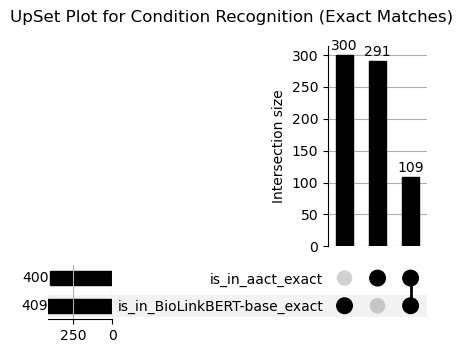

/opt/anaconda3/envs/neurotrial-analysis/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/opt/anaconda3/envs/neurotrial-analysis/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we 

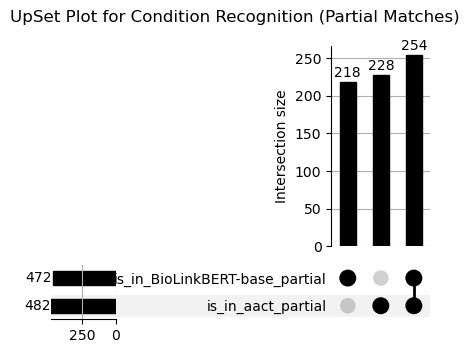

In [188]:
processed_df_conditions = process_entity_annotations(df_models_conditions, entity_type='condition', model_1='aact', model_2='BioLinkBERT-base')
sample_and_save_annotations(processed_df_conditions, entity_type='condition', model_1='aact', model_2='BioLinkBERT-base', match_type='exact')
sample_and_save_annotations(processed_df_conditions, entity_type='condition', model_1='aact', model_2='BioLinkBERT-base', match_type='partial')

In [189]:
df_models_interventsions = pd.read_csv("data/annotated_aact/neurotrial_ner_test_set/all_models_aggregated_all_entity_types_normalized.csv")[['nct_id','unique_drug_BioLinkBERT-base', 'unique_drug_aact']]#, 'unique_drug_BioLinkBERT-base', 'unique_drug_aact']]

/opt/anaconda3/envs/neurotrial-analysis/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/opt/anaconda3/envs/neurotrial-analysis/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we 

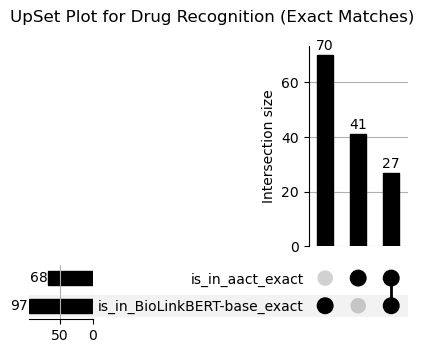

/opt/anaconda3/envs/neurotrial-analysis/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/opt/anaconda3/envs/neurotrial-analysis/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we 

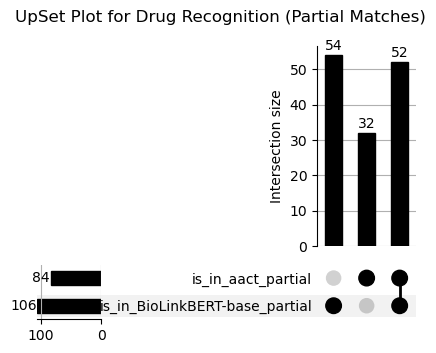

In [190]:
processed_df_drug = process_entity_annotations(df_models_interventsions, entity_type='drug', model_1='aact', model_2='BioLinkBERT-base')

sample_and_save_annotations(processed_df_drug, entity_type='drug', model_1='aact', model_2='BioLinkBERT-base', match_type='exact')
sample_and_save_annotations(processed_df_drug, entity_type='drug', model_1='aact', model_2='BioLinkBERT-base', match_type='partial')

## Manual Eval

In [312]:
import glob
import os

# Specify the directory containing the CSV files
analysis_directory = 'analysis/aact_vs_bert/'

# Use glob to find all files that start with "eval" and end with ".csv"
file_pattern = os.path.join(directory, 'eval*.csv')
files = glob.glob(file_pattern)

# Initialize an empty list to hold the DataFrames
dataframes_condition = []
dataframes_drug = []

# Iterate over the list of files and read each one into a DataFrame
for file in files:
    print("processing: ", file)
    df = pd.read_csv(file)
    print(len(df))
    if 'drug' in file:
        dataframes_drug.append(df)
    else:
        dataframes_condition.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df_cond = pd.concat(dataframes_condition, ignore_index=True)
combined_df_drug = pd.concat(dataframes_drug, ignore_index=True)

combined_df_cond.fillna(0, inplace=True)
combined_df_drug.fillna(0, inplace=True)


processing:  analysis/aact_vs_bert/eval_sample_aact_false_BioLinkBERT-base_true_drug_partial.csv
20
processing:  analysis/aact_vs_bert/eval_sample_aact_true_BioLinkBERT-base_false_drug_partial.csv
20
processing:  analysis/aact_vs_bert/eval_sample_aact_false_BioLinkBERT-base_true_condition_partial.csv
20
processing:  analysis/aact_vs_bert/eval_sample_aact_true_BioLinkBERT-base_false_condition_partial.csv
20


In [313]:
combined_df_cond.head(5)

,nct_id,unique_condition_BioLinkBERT-base,unique_condition_aact,all_annotations,all_unique_annotations,condition_is_in_aact_exact,condition_is_in_BioLinkBERT-base_exact,condition_is_in_aact_partial,condition_is_in_BioLinkBERT-base_partial,tp_aact,tp_bert,fn_aact,fn_bert,fp_aact,fp_bert,not_in_text,synonym,tricky,bert_extraction_error
0,NCT02139436,acquired cardiovascular disease|acute sci|card...,spinal cord injuries,spinal cord injuries|acquired cardiovascular d...,cardiovascular disease,False,True,False,True,0,1,1,0,0,0,0,0,0.0,0.0
1,NCT03787693,asymmetry|stroke|walking asymmetry,stroke,stroke|asymmetry|stroke|walking asymmetry,asymmetry,False,True,False,True,0,1,1,0,0,0,0,0,0.0,0.0
2,NCT00295139,abuse|drug abuse|dual disordered|spmi,substance dependence|mood disorders|schizophrenia,substance dependence|mood disorders|schizophre...,abuse,False,True,False,True,1,1,0,0,0,0,0,1,0.0,0.0
3,NCT01407341,metastatic cancer|metastatic spine cancer|spin...,spinal bone metastases|spinal cord compression...,spinal bone metastases|spinal cord compression...,spine cancer,False,True,False,True,1,1,0,0,0,0,0,1,0.0,0.0
4,NCT05462678,cognitive deficits|memory deficits|motor disab...,multiple sclerosis,multiple sclerosis|cognitive deficits|memory d...,cognitive deficits,False,True,False,True,0,1,1,0,0,0,0,0,0.0,0.0


In [314]:
combined_df_cond.shape

(40, 19)

In [315]:
sum(combined_df_cond['tp_aact'])

25

In [316]:
combined_df = combined_df_cond.copy()

In [320]:
def viz_eval_cases(combined_df, entity_type):
    # Create the unique_tp_aact and unique_tp_bert columns
    combined_df['tp_unique_aact'] = (combined_df['tp_aact'] == 1) & (combined_df['tp_bert'] == 0)
    combined_df['tp_unique_aact_not_in_text'] = (combined_df['tp_aact'] == 1) & (combined_df['tp_bert'] == 0) & (combined_df['not_in_text'] == 1)

    combined_df['tp_unique_bert'] = (combined_df['tp_aact'] == 0) & (combined_df['tp_bert'] == 1)
    
    # Convert boolean to integer (optional, if needed for plotting)
    combined_df['tp_unique_aact'] = combined_df['tp_unique_aact'].astype(int)
    combined_df['tp_unique_bert'] = combined_df['tp_unique_bert'].astype(int)
    combined_df['tp_unique_aact_not_in_text'] = combined_df['tp_unique_aact_not_in_text'].astype(int)

    combined_df.to_csv(f'analysis/aact_vs_bert/eval_combined_{entity_type}.csv')

    # Filter only numerical columns
    numerical_columns = combined_df.select_dtypes(include=['number']).drop(columns=['tp_aact', 'tp_bert','tricky', 'not_in_text','bert_extraction_error'])
    numerical_columns = numerical_columns[['fp_aact', 'fp_bert', 'tp_unique_aact_not_in_text', 'tp_unique_aact', 'tp_unique_bert', 'synonym']]
    numerical_columns.rename(columns={'synonym': 'tp_both_synonyms'}, inplace=True)

    # Plot a bar chart for each numerical column
    ax = numerical_columns.sum().plot(kind='barh', figsize=(10, 6), legend=False,  zorder=2, color='#009E73')
    plt.title(f'Evaluation of performance for {entity_type.capitalize()}', fontsize=13)
    plt.xlabel('Case frequency', fontsize=13)
    #plt.ylabel('Sum')
    #plt.xticks(rotation=90)
    ax.grid(axis='x',linestyle='--', alpha=0.6, zorder=0)
    
    # Add numbers on top of the bars
    for i in ax.containers:
        ax.bar_label(i, label_type='edge', fontsize=13)
    
    plt.tight_layout()
    plt.tick_params(axis='y', labelsize=13)
    plt.tick_params(axis='x', labelsize=13)
    # Show the plot
    plt.savefig(f'viz/aact_vs_bert/manual_eval_partial_{entity_type}.png')
    plt.show()

In [348]:
def viz_eval_cases(combined_df, entity_type):
    # Create the unique_tp_aact and unique_tp_bert columns
    combined_df['tp_unique_aact'] = (combined_df['tp_aact'] == 1) & (combined_df['tp_bert'] == 0)
    combined_df['tp_unique_aact_not_in_text'] = (combined_df['tp_aact'] == 1) & (combined_df['tp_bert'] == 0) & (combined_df['not_in_text'] == 1)
    combined_df['tp_unique_bert'] = (combined_df['tp_aact'] == 0) & (combined_df['tp_bert'] == 1)

    # Convert boolean to integer (optional, if needed for plotting)
    combined_df['tp_unique_aact'] = combined_df['tp_unique_aact'].astype(int)
    combined_df['tp_unique_bert'] = combined_df['tp_unique_bert'].astype(int)
    combined_df['tp_unique_aact_not_in_text'] = combined_df['tp_unique_aact_not_in_text'].astype(int)

    combined_df.to_csv(f'analysis/aact_vs_bert/eval_combined_{entity_type}.csv')

    # Filter only numerical columns
    numerical_columns = combined_df.select_dtypes(include=['number']).drop(columns=['tp_aact', 'tp_bert', 'tricky', 'not_in_text', 'bert_extraction_error'])
    numerical_columns = numerical_columns[['fp_aact', 'fp_bert', 'tp_unique_aact_not_in_text', 'tp_unique_aact', 'tp_unique_bert', 'synonym']]
    numerical_columns.rename(columns={'synonym': 'tp_both_synonyms'}, inplace=True)

    # Calculate the total number of cases
    total_cases = len(combined_df)
    # Calculate the sum and percentage for each column
    column_sums = numerical_columns.sum()
    column_percentages = (column_sums / total_cases) * 100

    # Plot a bar chart for each numerical column
    ax = numerical_columns.sum().plot(kind='barh', figsize=(10, 6), legend=False, zorder=2, color='#009E73')
    plt.title(f'Evaluation of performance for {entity_type.capitalize()}', fontsize=13)
    plt.xlabel('Case frequency', fontsize=13)
    ax.grid(axis='x', linestyle='--', alpha=0.6, zorder=0)

    # Add numbers and percentages next to the bars
    for container in ax.containers:
        labels = [f'{int(value)} ({percentage:.0f}%)' for value, percentage in zip(container.datavalues, column_percentages)]
        ax.bar_label(container, labels=labels, label_type='edge', fontsize=13)

    plt.tight_layout()
    plt.tick_params(axis='y', labelsize=13)
    plt.tick_params(axis='x', labelsize=13)
    plt.xlim(0, max(column_sums) + 3)  # Adjusted to max count for relevancy

    # Save and show the plot
    plt.savefig(f'viz/aact_vs_bert/manual_eval_partial_{entity_type}.png')
    plt.show()

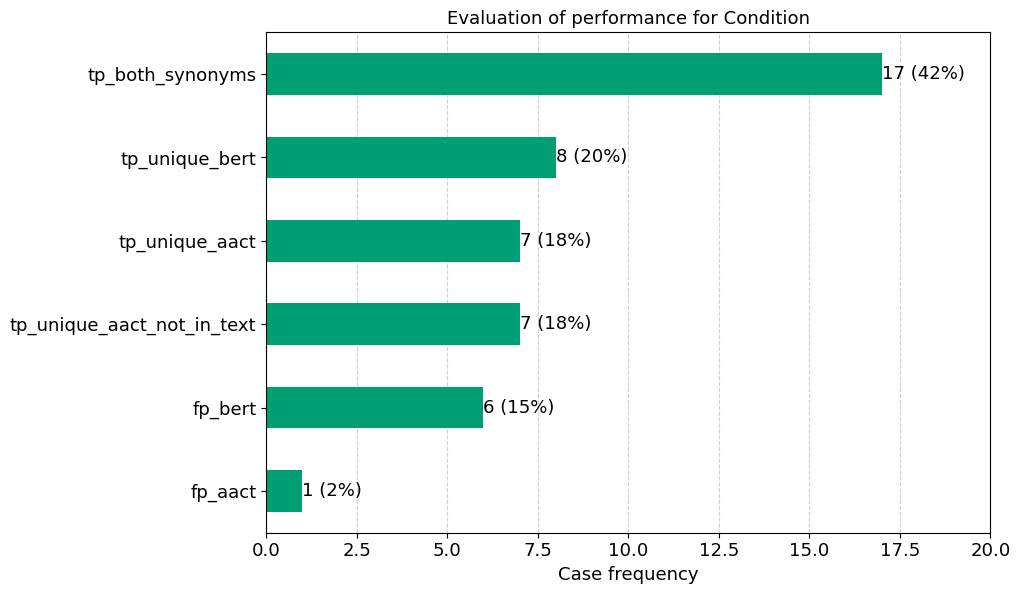

In [349]:
viz_eval_cases(combined_df_cond, 'condition')

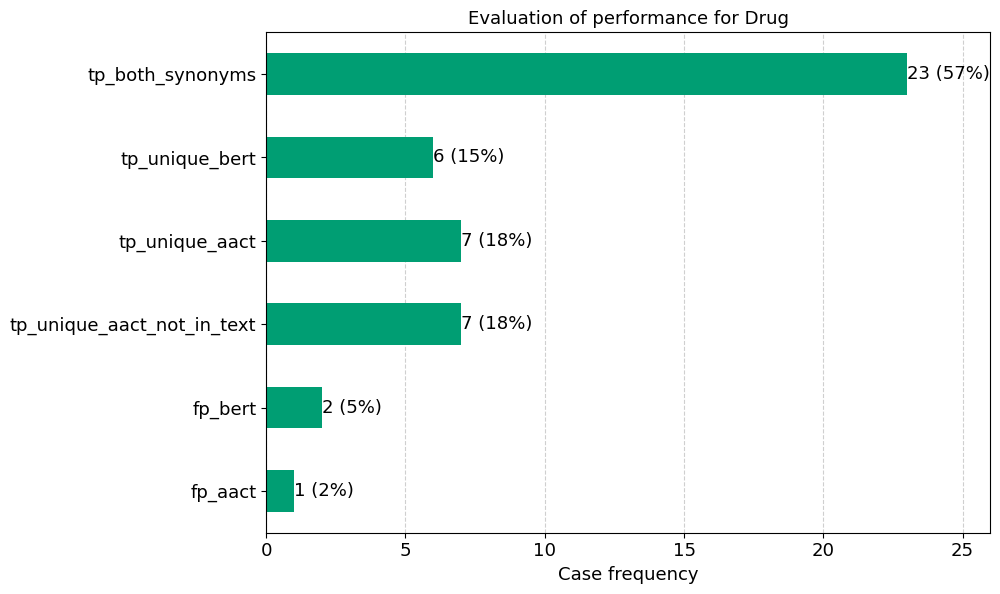

In [350]:
viz_eval_cases(combined_df_drug, 'drug')

## Comparison aact vs bert

In [93]:
df = pd.read_excel("data/quality_checks/biolinkbert_annotations_sample2_50_reviewed.xlsx")

In [94]:
df.head()

,nct_id,canonical_aact_interventions,canonical_BioLinkBERT-base_interventions,canonical_aact_conditions,canonical_BioLinkBERT-base_conditions,"bert_performance (0: equal, 1: better, 2: worse)",tricky,comment
0,NCT01942161,aripiprazole high (24 - 30 mg/day)|aripiprazol...,aripiprazole,schizophrenia,schizophrenia,1,NaN,NaN
1,NCT02363517,sofosbuvir/ledispasvir fixed dose combination ...,ledipasvir|sofosbuvir,"substance abuse, intravenous|hepatitis c",hepatitis c virus,2,1.0,substance abuse indirectly implied
2,NCT03945279,biib100,biib100,amyotrophic lateral sclerosis,amyotrophic lateral sclerosis,0,NaN,NaN
3,NCT01137110,NaN,levetiracetam,subarachnoid hemorrhage,seizures|subarachnoid hemorrhage,1,NaN,NaN
4,NCT00004418,glyceryl trierucate/glyceryl trioleate,glyceryl trierucate|glyceryl trioleate|lorenzo...,adrenoleukodystrophy,adrenoleukodystrophy,1,NaN,NaN


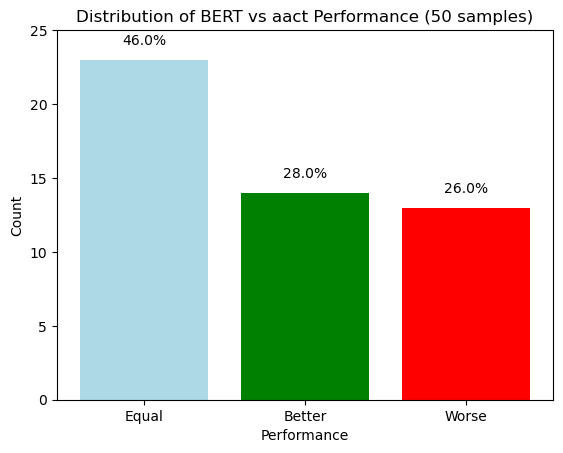

In [98]:
# Group by 'bert_performance' and count occurrences
performance_distribution = df['bert_performance (0: equal, 1: better, 2: worse)'].value_counts()

# Define labels for each category
labels = ['Equal', 'Better', 'Worse']

# Plot the bar chart
plt.bar(labels, performance_distribution, color=['lightblue', 'green', 'red'])

# Calculate the percentage of each category
total_count = performance_distribution.sum()
percentages = [count / total_count * 100 for count in performance_distribution]

# Annotate bars with percentages
for i, percentage in enumerate(percentages):
    plt.text(i, performance_distribution[i] + 1, f"{percentage:.1f}%", ha='center')
    
# Set the y-axis limit to reach 30
plt.ylim(0, 25)
# Set the title and labels
plt.title('Distribution of BERT vs aact Performance (50 samples)')
plt.xlabel('Performance')
plt.ylabel('Count')

plt.savefig("viz/bert_vs_aact_manual.png")
# Show the plot
plt.show()

### BERT advantages
- more details
- more specific
- easier to aggregate

In [96]:
df[df['bert_performance (0: equal, 1: better, 2: worse)'] == 1]

,nct_id,canonical_aact_interventions,canonical_BioLinkBERT-base_interventions,canonical_aact_conditions,canonical_BioLinkBERT-base_conditions,"bert_performance (0: equal, 1: better, 2: worse)",tricky,comment
0,NCT01942161,aripiprazole high (24 - 30 mg/day)|aripiprazol...,aripiprazole,schizophrenia,schizophrenia,1,NaN,NaN
3,NCT01137110,NaN,levetiracetam,subarachnoid hemorrhage,seizures|subarachnoid hemorrhage,1,NaN,NaN
4,NCT00004418,glyceryl trierucate/glyceryl trioleate,glyceryl trierucate|glyceryl trioleate|lorenzo...,adrenoleukodystrophy,adrenoleukodystrophy,1,NaN,NaN
5,NCT00829218,type: other,glutamate|msg,fibromyalgia|irritable bowel syndrome,fibromyalgia|ibs|irritable bowel syndrome,1,NaN,NaN
7,NCT00331825,risperidone and olanzapine,olanzapine|risperidone,extrapyramidal syndrome|schizophrenia,eps|neuroleptic-induced acute dystonia|parkins...,1,1.0,extrapyramidal syndrome not in the text
8,NCT03406702,cx-8998,cx-8998,epilepsy,absence seizures|idiopathic generalized epilepsy,1,1.0,only epilepsy missing in bert
10,NCT06100276,amt-162,amt-162|therapy,amyotrophic lateral sclerosis,rapidly progressive als|sod1 amyotrophic later...,1,1.0,abbreviations not well disambiguated
11,NCT00095524,aripiprazole,aripiprazole|olanzapine,schizoaffective disorder|psychotic disorders|b...,overweight|psychotic disorders|schizoaffective...,1,NaN,NaN
16,NCT01957774,thr-18,alteplase|thr-18|tissue plasminogen activator,stroke,acute ischemic stroke|ischemic strokes|stroke,1,NaN,NaN
27,NCT01883505,levodopa and carbidopa,carbidopa|ld|levodopa|nd0612,parkinson disease,- treated|motor fluctuations|parkinson disease,1,NaN,NaN


### Issues
- main issue: mentions available in other parts of the data, e.g. brief title, detailed trial description
- extractions noise

In [97]:
df[df['bert_performance (0: equal, 1: better, 2: worse)'] == 2]

,nct_id,canonical_aact_interventions,canonical_BioLinkBERT-base_interventions,canonical_aact_conditions,canonical_BioLinkBERT-base_conditions,"bert_performance (0: equal, 1: better, 2: worse)",tricky,comment
1,NCT02363517,sofosbuvir/ledispasvir fixed dose combination ...,ledipasvir|sofosbuvir,"substance abuse, intravenous|hepatitis c",hepatitis c virus,2,1.0,substance abuse indirectly implied
9,NCT00538642,ziprasidone,antipsychotics|ziprasidone,schizoaffective disorder|psychotic disorders|b...,bipolar disorder|diabetes|diabetic|pre-diabeti...,2,1.0,NaN
14,NCT03432871,type: dietary supplement,nicotinamide riboside,progressive external ophthalmoplegia|ophthalmo...,mitochondrial disease|mitochondrial disorders,2,1.0,ophthalmoplegia mentioned only in the detailed...
19,NCT00986115,memantine,memantine,epilepsy,alzheimer disease|epilepsy|seizures,2,1.0,alzheimer disease is a false positive
22,NCT01280006,celecoxib|indomethacin,NaN,stroke|hypertension|cardiovascular diseases|sl...,intermittent hypoxia,2,1.0,Arms and Interventions field of AACT? Missing ...
23,NCT02034474,tocilizumab,il-6 receptor antibody|tocilizumab,schizoaffective disorder|psychotic disorders|s...,"residual positive, negative, and cognitive sym...",2,NaN,NaN
25,NCT01069159,propranolol hydrochloride,propranolol,"stress disorders, post-traumatic|traumatic memory",propranolol treatment of traumatic memories|tr...,2,NaN,NaN
28,NCT00320723,"bupropion, transdermal nicotine patch",bupropion,schizoaffective disorder|psychotic disorders|s...,major mental illness|smoking,2,1.0,schizophrenia mentioned in brief title and det...
34,NCT00242177,actos (pioglitazone),NaN,"multiple sclerosis, relapsing-remitting","multiple sclerosis|multiple sclerosis, relapsi...",2,1.0,drug was mentioned in the detailed description
35,NCT01453127,i-123 ioflupane solution injection prior to sp...,NaN,rem sleep behavior disorder|dementia|parkinson...,alzheimer disease|dementia with lewy bodies|mi...,2,1.0,drug was mentioned in the detailed description


# disease-intervention pairs

In [99]:
if evaluate_snomed_link:
    suffix = "_sapbert"
else:
    suffix = ""

In [101]:
pairs_aact = pd.read_csv(f"./analysis/disease_intervenion_pairs_aact{suffix}.csv", index_col=0)
pairs_aact['disease_intervention_pair'] = pairs_aact['disease_intervention_pair'].str.lower()

pairs_bert = pd.read_csv(f"./analysis/disease_intervenion_pairs_biolinkbert{suffix}.csv", index_col=0)
pairs_bert['disease_intervention_pair'] = pairs_bert['disease_intervention_pair'].str.lower()


In [102]:
grouped_df_aact = pairs_aact.groupby('disease_intervention_pair').agg(
    nct_ids_aact=('nct_id', list),              # Create a list of nct_ids
    count_nct_ids_aact=('nct_id', 'nunique')    # Count unique nct_ids
).reset_index()
grouped_df_aact = grouped_df_aact.sort_values(by='count_nct_ids_aact', ascending=False)
grouped_df_aact

,disease_intervention_pair,nct_ids_aact,count_nct_ids_aact
29111,schizophrenia - risperidone (substance),"[NCT00000374, NCT00006195, NCT00014001, NCT000...",170
28919,schizophrenia - olanzapine (substance),"[NCT00000374, NCT00001656, NCT00006195, NCT000...",128
28545,schizophrenia - aripiprazole (substance),"[NCT00036127, NCT00036361, NCT00044655, NCT000...",109
28943,schizophrenia - paliperidone palmitate,"[NCT00073320, NCT00077714, NCT00078039, NCT000...",83
7995,delirium - dexmedetomidine (substance),"[NCT00095251, NCT00351299, NCT00455143, NCT004...",82
...,...,...,...
12327,facioscapulohumeral muscular dystrophy (disord...,[NCT03123913],1
12326,facioscapulohumeral muscular dystrophy (disord...,[NCT00104078],1
12325,facioscapulohumeral muscular dystrophy (disord...,[NCT02948244],1
12324,facioscapulohumeral muscular dystrophy (disord...,[NCT01970735],1


In [103]:
grouped_df_bert = pairs_bert.groupby('disease_intervention_pair').agg(
    nct_ids_bert=('nct_id', list),              # Create a list of nct_ids
    count_nct_ids_bert=('nct_id', 'nunique')    # Count unique nct_ids
).reset_index()
grouped_df_bert = grouped_df_bert.sort_values(by='count_nct_ids_bert', ascending=False)


In [104]:
grouped_df_bert

,disease_intervention_pair,nct_ids_bert,count_nct_ids_bert
39041,schizophrenia - anti-psychotic agent (substance),"[NCT00000371, NCT00001656, NCT00005658, NCT000...",261
32716,parkinson's disease - levodopa (substance),"[NCT00004576, NCT00004733, NCT00006077, NCT000...",205
39435,schizophrenia - risperidone (substance),"[NCT00000267, NCT00006195, NCT00014001, NCT000...",176
39343,schizophrenia - olanzapine (substance),"[NCT00001656, NCT00006195, NCT00007774, NCT000...",134
41268,smoker - nicotine,"[NCT00108537, NCT00115687, NCT00135746, NCT001...",108
...,...,...,...
17360,frame-shift mutation - multiple of the median ...,[NCT00844597],1
17361,frame-shift mutation - naftifine hydrochloride,[NCT02500381],1
17362,frame-shift mutation - trvl 61866,[NCT00844597],1
17363,fraxinus americana specific diagnostic allerge...,[NCT00224640],1


In [105]:
# Merge the DataFrames on 'disease_intervention_pair'
merged_df = pd.merge(grouped_df_aact, grouped_df_bert, on='disease_intervention_pair', how='outer')

# Function to calculate intersections and differences
def calculate_overlaps(row):
    ids_a = set(row['nct_ids_aact']) if isinstance(row['nct_ids_aact'], list) else set()
    ids_b = set(row['nct_ids_bert']) if isinstance(row['nct_ids_bert'], list) else set()
    overlap = ids_a & ids_b
    unique_aact = ids_a - ids_b
    unique_bert = ids_b - ids_a
    return pd.Series({
        'overlap_count': len(overlap),
        'unique_aact_count': len(unique_aact),
        'unique_bert_count': len(unique_bert),
        'overlap_values': list(overlap),
        'unique_aact_values': list(unique_aact),
        'unique_bert_values': list(unique_bert)
    })

# Apply the function to each row
merged_df[['overlap_count', 'unique_aact_count', 'unique_bert_count', 
           'overlap_values', 'unique_aact_values', 'unique_bert_values']] = merged_df.apply(calculate_overlaps, axis=1)



In [106]:
merged_df.head(2)

,disease_intervention_pair,nct_ids_aact,count_nct_ids_aact,nct_ids_bert,count_nct_ids_bert,overlap_count,unique_aact_count,unique_bert_count,overlap_values,unique_aact_values,unique_bert_values
0,1011 - 1011,[NCT03829878],1.0,NaN,NaN,0,1,0,[],[NCT03829878],[]
1,115 - adult vaccine product containing only ac...,NaN,NaN,[NCT01642589],1.0,0,0,1,[],[],[NCT01642589]


In [107]:
merged_df['combined_frq'] = merged_df['overlap_count'] + merged_df['unique_aact_count'] + merged_df['unique_bert_count']
merged_df = merged_df.sort_values(by='combined_frq', ascending=False)


In [109]:
merged_df.head()

,disease_intervention_pair,nct_ids_aact,count_nct_ids_aact,nct_ids_bert,count_nct_ids_bert,overlap_count,unique_aact_count,unique_bert_count,overlap_values,unique_aact_values,unique_bert_values,combined_frq
60470,schizophrenia - anti-psychotic agent (substance),"[NCT00931996, NCT01050582, NCT01192880, NCT013...",10.0,"[NCT00000371, NCT00001656, NCT00005658, NCT000...",261.0,5,5,256,"[NCT03548155, NCT02983188, NCT02360319, NCT020...","[NCT05039489, NCT00931996, NCT01050582, NCT011...","[NCT00538642, NCT00169026, NCT00757705, NCT021...",266
61230,schizophrenia - risperidone (substance),"[NCT00000374, NCT00006195, NCT00014001, NCT000...",170.0,"[NCT00000267, NCT00006195, NCT00014001, NCT000...",176.0,95,75,81,"[NCT00526877, NCT00761670, NCT02019329, NCT001...","[NCT02051387, NCT00418873, NCT02650102, NCT021...","[NCT03237052, NCT00539071, NCT02765555, NCT008...",251
50703,parkinson's disease - levodopa (substance),"[NCT00004733, NCT00096720, NCT00153972, NCT004...",26.0,"[NCT00004576, NCT00004733, NCT00006077, NCT000...",205.0,18,8,187,"[NCT01351168, NCT00153972, NCT00004733, NCT015...","[NCT03119636, NCT01770145, NCT01283594, NCT062...","[NCT03582371, NCT00462007, NCT02225548, NCT005...",213
60989,schizophrenia - olanzapine (substance),"[NCT00000374, NCT00001656, NCT00006195, NCT000...",128.0,"[NCT00001656, NCT00006195, NCT00007774, NCT000...",134.0,77,51,57,"[NCT00485823, NCT00827918, NCT00169065, NCT002...","[NCT02051387, NCT02650102, NCT01129674, NCT001...","[NCT01420575, NCT02804568, NCT00078039, NCT000...",185
60483,schizophrenia - aripiprazole (substance),"[NCT00036127, NCT00036361, NCT00044655, NCT000...",109.0,"[NCT00036361, NCT00088049, NCT00095524, NCT001...",99.0,61,48,38,"[NCT00737256, NCT00352339, NCT00392197, NCT013...","[NCT02650102, NCT01104766, NCT02054702, NCT011...","[NCT00325689, NCT03237052, NCT01742390, NCT038...",147


In [110]:
# Sorting the DataFrame by 'combined_frq' and selecting the top 20
top_df = merged_df.sort_values(by='combined_frq', ascending=False).head(20)

# Calculate proportions scaled to 100
top_df['total'] = top_df['overlap_count'] + top_df['unique_aact_count'] + top_df['unique_bert_count']
top_df['overlap_pct'] = (top_df['overlap_count'] / top_df['total']) * 100
top_df['unique_aact_pct'] = (top_df['unique_aact_count'] / top_df['total']) * 100
top_df['unique_bert_pct'] = (top_df['unique_bert_count'] / top_df['total']) * 100
top_df.head()

,disease_intervention_pair,nct_ids_aact,count_nct_ids_aact,nct_ids_bert,count_nct_ids_bert,overlap_count,unique_aact_count,unique_bert_count,overlap_values,unique_aact_values,unique_bert_values,combined_frq,total,overlap_pct,unique_aact_pct,unique_bert_pct
60470,schizophrenia - anti-psychotic agent (substance),"[NCT00931996, NCT01050582, NCT01192880, NCT013...",10.0,"[NCT00000371, NCT00001656, NCT00005658, NCT000...",261.0,5,5,256,"[NCT03548155, NCT02983188, NCT02360319, NCT020...","[NCT05039489, NCT00931996, NCT01050582, NCT011...","[NCT00538642, NCT00169026, NCT00757705, NCT021...",266,266,1.879699,1.879699,96.240602
61230,schizophrenia - risperidone (substance),"[NCT00000374, NCT00006195, NCT00014001, NCT000...",170.0,"[NCT00000267, NCT00006195, NCT00014001, NCT000...",176.0,95,75,81,"[NCT00526877, NCT00761670, NCT02019329, NCT001...","[NCT02051387, NCT00418873, NCT02650102, NCT021...","[NCT03237052, NCT00539071, NCT02765555, NCT008...",251,251,37.848606,29.880478,32.270916
50703,parkinson's disease - levodopa (substance),"[NCT00004733, NCT00096720, NCT00153972, NCT004...",26.0,"[NCT00004576, NCT00004733, NCT00006077, NCT000...",205.0,18,8,187,"[NCT01351168, NCT00153972, NCT00004733, NCT015...","[NCT03119636, NCT01770145, NCT01283594, NCT062...","[NCT03582371, NCT00462007, NCT02225548, NCT005...",213,213,8.450704,3.755869,87.793427
60989,schizophrenia - olanzapine (substance),"[NCT00000374, NCT00001656, NCT00006195, NCT000...",128.0,"[NCT00001656, NCT00006195, NCT00007774, NCT000...",134.0,77,51,57,"[NCT00485823, NCT00827918, NCT00169065, NCT002...","[NCT02051387, NCT02650102, NCT01129674, NCT001...","[NCT01420575, NCT02804568, NCT00078039, NCT000...",185,185,41.621622,27.567568,30.810811
60483,schizophrenia - aripiprazole (substance),"[NCT00036127, NCT00036361, NCT00044655, NCT000...",109.0,"[NCT00036361, NCT00088049, NCT00095524, NCT001...",99.0,61,48,38,"[NCT00737256, NCT00352339, NCT00392197, NCT013...","[NCT02650102, NCT01104766, NCT02054702, NCT011...","[NCT00325689, NCT03237052, NCT01742390, NCT038...",147,147,41.496599,32.653061,25.850340


In [111]:
top_df.to_csv(f"analysis/overlapping_unique_nct_ids{suffix}.csv")

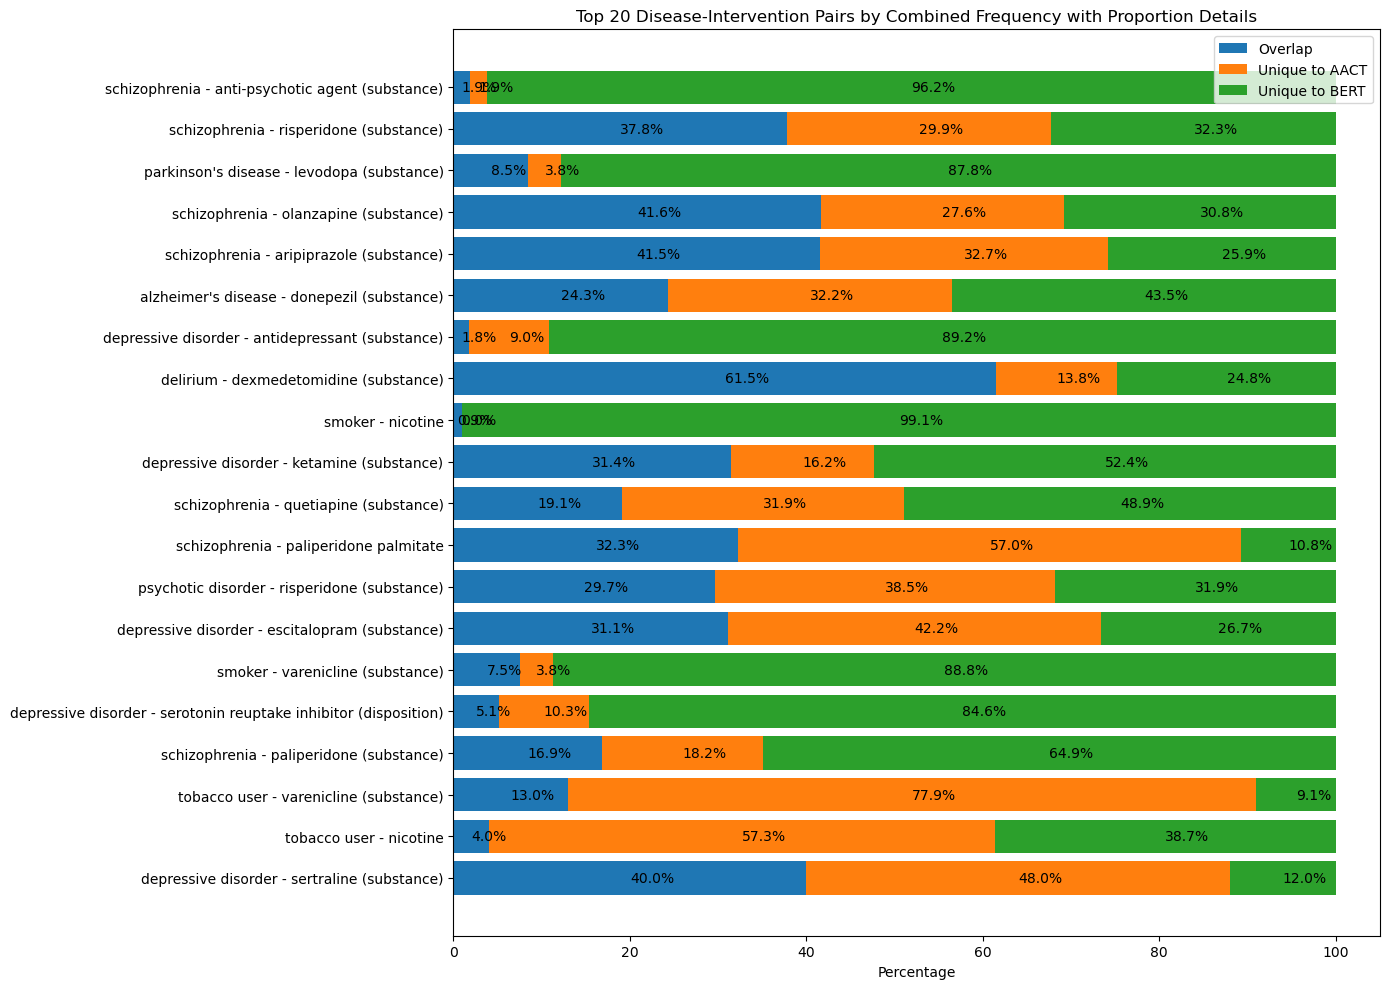

In [112]:
# Plotting
fig, ax = plt.subplots(figsize=(14, 10))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Define color scheme
bars_overlap = ax.barh(top_df['disease_intervention_pair'], top_df['overlap_pct'], color=colors[0], label='Overlap')
bars_unique_aact = ax.barh(top_df['disease_intervention_pair'], top_df['unique_aact_pct'], left=top_df['overlap_pct'], color=colors[1], label='Unique to AACT')
bars_unique_bert = ax.barh(top_df['disease_intervention_pair'], top_df['unique_bert_pct'], left=top_df['overlap_pct'] + top_df['unique_aact_pct'], color=colors[2], label='Unique to BERT')

# Add labels to the bars
def add_labels(bars):
    for bar in bars:
        width = bar.get_width()
        label_x_pos = bar.get_x() + width / 2
        ax.text(label_x_pos, bar.get_y() + bar.get_height() / 2, f'{width:.1f}%', va='center')

add_labels(bars_overlap)
add_labels(bars_unique_aact)
add_labels(bars_unique_bert)

# Invert y-axis to have the first item at the top
ax.invert_yaxis()

ax.set_xlabel('Percentage')
ax.set_title('Top 20 Disease-Intervention Pairs by Combined Frequency with Proportion Details')
ax.set_yticks(range(len(top_df)))
ax.set_yticklabels(top_df['disease_intervention_pair'])
ax.legend()
plt.tight_layout()
plt.savefig(f'viz/bert_vs_aacts_drug_disease_pairs_nctids{suffix}.png')

plt.show()